<img src="http://www.ensai.fr/files/_media/images/l_ecole/Partenaires/Ecoles/ensae_logo_dev.png" width="400" height="80" />
<br>
<div class="monika" align="center" style="font-size:200%"> Stochastic Optimization and Automatic Differentiation for Machine Learning </div>
<br>
<div style="text-align: center"> Selim Dekali & Mathis Linger </div>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### 1] Introduction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import LinearSVC
import sklearn.metrics.pairwise as kernel
from sklearn.model_selection import train_test_split
from sklearn import metrics

Consider:
- $x_1,..., x_n$ $\in$ $\mathbb{R}^d$
- $y_1,...,y_n$ $\in$ $(-1, 1)$
- $\lambda > 0$ a regularization parameter
- $\phi_1,...,\phi_n$ a sequence of scalars convex functions
- Since we are working on the SVM problem (with linear kernels and no bias term), we set $\phi_i(a) = max(0,1-y_ia)$ (Hinge loss)

For solving SVM, there are 2 approaches:
- stochastic gradient descent (SGD), which aims to minimize the following primal problem:
\begin{equation}
min_{w \text{ } \in \text{ } R^d} \big[ \frac{1}{n} \sum\limits_{i=1}^n \phi_i(w^Tx_i) + \frac{\lambda}{2}||w||^2\big]
\end{equation}
- dual coordinate ascent (DCA), which aims to maximize the following dual problem:
\begin{equation}
max_{\alpha \text{ } \in \text{ } R^n} \big[ \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i) - \frac{\lambda}{2} \big|\big|\frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i \big|\big|^2\big]
\end{equation}
here, for each $i$, $\phi_i^*: \mathbb{R} \rightarrow \mathbb{R}$ is the convex conjugate of $\phi_i$, namely $\phi_i^*(u) = max_z(zu - \phi_i(z))$

If we define, $w(\alpha) = \frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i$, then we have that $w(\alpha^*) = w^*$ where $\alpha^*$ is an optimal solution of the dual problem.

### 2] Dual coordinate ascent for SVM

***
<center>___SDCA___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $i$<br>
Find $\Delta\alpha_i$ to maximize $-\phi_i^*(-(\alpha_i^{(t-1)}+\Delta\alpha_i)) - \frac{\lambda n}{2} ||w^{(t-1)}+(\lambda n)^{-1} \Delta\alpha_ix_i||^2$<br>
$\alpha^{(t)} \leftarrow \alpha^{(t-1)}+\Delta\alpha_ie_i$<br>
$w^{(t)} \leftarrow w^{(t-1)}+(\lambda n)^{-1}\Delta\alpha_ix_i$<br>
 
___Output (Averaging option):___<br>
> Let $\bar{\alpha} = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T \alpha^{(t-1)}$<br>
Let $\bar{w} = w(\bar{\alpha}) = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T w^{(t-1)}$<br>
return $\bar{w}$<br>

___Output (Random option):___<br>
> Let $\bar{\alpha} = \alpha^{(t)}$ and $\bar{w} = w^{(t)}$ for some random $t \in T_0+1,...T$<br>
return $\bar{w}$

***

___Close formula to maximize $-\phi_i^*(-(\alpha_i^{(t-1)}+\Delta\alpha_i)) - \frac{\lambda n}{2} ||w^{(t-1)}+(\lambda n)^{-1} \Delta\alpha_ix_i||^2$:___

We want to $max_{\alpha \text{ } \in \text{ } R^n} D(\alpha)$ with $D(\alpha) = \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i) - \frac{\lambda}{2} \big|\big|\frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i \big|\big|^2 = - \frac{1}{2\lambda n^2} \alpha^T X^T X \alpha + \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i)$

At each iteration, we have to maximize the updated dual objective defined as:
\begin{equation}
\begin{aligned}
D(\alpha_t+\Delta\alpha_i e_i) = &\frac{-1}{2\lambda n^2} (\alpha_t+\Delta\alpha_i e_i)^T X^T X (\alpha_t+\Delta\alpha_i e_i) - \frac{1}{n}\sum\limits_{i=1}^n \phi_i^*(-\alpha_t-\Delta\alpha_i e_i)\\
=& \frac{-1}{2\lambda n^2} \alpha_t^T X^T X \alpha_t - \frac{1}{\lambda n^2} \alpha_t^T X^T X \Delta\alpha_ie_i - \frac{1}{2\lambda n^2} (\Delta\alpha_i e_i)^T X^T X (\Delta\alpha_i e_i) - \frac{1}{n}\sum\limits_{i=1}^n \phi_i^*(-\alpha_t-\Delta\alpha_i e_i)\\
\end{aligned}
\end{equation}

By setting:
\begin{equation}
\begin{aligned}
Constant =& \frac{-1}{2\lambda n^2} \alpha_t^T X^T X \alpha_t - \frac{1}{n}\sum\limits_{\substack{i=1 \\ i\neq j}}^n \phi_j^*(-\alpha_t-\Delta\alpha_j e_j)\\
A =& \frac{1}{\lambda n} x_i^T x_i = \frac{1}{\lambda n}||x_i||^2\\
B=& x_i^T \frac{X \alpha_t}{\lambda n} = x_i^T w_t
\end{aligned}
\end{equation}

we get:
\begin{equation}
\begin{aligned}
D(\alpha_t+\Delta\alpha_i e_i) \propto \frac{-A}{2} (\Delta\alpha_i)^2 - B \Delta\alpha_i - \phi^*_i(-\alpha_i\Delta\alpha_i)
\end{aligned}
\end{equation}

We recall that in the case of SVM, we use the Hinge loss, i.e.:
\begin{equation}
\phi_i(a) = max(0,1-y_ia)
\end{equation}
and its conjugate is given by:
\begin{equation}
\phi^*_i(u) =
    \begin{cases}
      y_i u & \text{if} -1\leq y_iu\leq 0\\
      +\infty & \text{otherwise}
    \end{cases} 
\end{equation}

Then, considering that $-1\leq y_iu\leq 0$, we can maximize $D(\alpha_t+\Delta\alpha_i e_i)$ by $\Delta\alpha_i$ by:
\begin{equation}
\tilde{\Delta\alpha_i} = \frac{y_i -B}{A}
\end{equation}

Finally, if we incorporate the constraint $-1\leq -y_i(\alpha_i + \Delta\alpha_i)\leq 0 \leftrightarrow 0\leq y_i(\alpha_i + \Delta\alpha_i)\leq 1$, we obtain the update:
\begin{equation}
\Delta\alpha_i = \frac{1}{y_i}max(0, min(1, y_i(\alpha_i + \tilde{\Delta\alpha_i}))) - \alpha_i
\end{equation}

In [4]:
def dual_primal(alpha, X, lambda_):
    return X.T.dot(alpha)/(lambda_*X.shape[0])

In this implementation, we set $T_0 = \frac{T}{2}$ for the averaging option as suggested in the paper.

In [5]:
def SDCA(X, y, lambda_ = 1, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    for t in tqdm(range(nb_iteration)):
        i = np.random.randint(0, n)
        A = (1/(lambda_*n))*np.linalg.norm(X[i], 2)**2
        B = X[i].dot(w[t])
        delta_alpha = (y[i]-B)/A
        delta_alpha_constrained = (1/y[i])*max(0, min(1, y[i]*(delta_alpha+alpha[t][i]))) - alpha[t][i]
        e_i = np.zeros(n)
        e_i[i] = 1.
        alpha.append(alpha[t]+delta_alpha_constrained*e_i)
        w.append(dual_primal(alpha[t+1], X, lambda_))
        # Condition to store the weights at each epoch
        if t%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

We found a paper proposing a mini batch version of SDCA. We can implement it in order to compare with the stochastic version. The paper is available at https://pdfs.semanticscholar.org/b0b5/13b601e28db45a02ed4b19801af0cb29e462.pdf#page3

Original optimization problem:
$$
\begin{aligned}
&\min_{w,b} \frac{1}{2} w.w \\
& \text{subject to : } (w.x_j) y_j \geq 1 \forall j
\end{aligned}
$$

We will use the Lagragian to solve the problem:
$$
L(w,\alpha) = \frac{1}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]
$$
Our goal now is to solve: $$\min_{w,b} \max_{\alpha} L(w, \alpha) $$
(primal) :  $$ \min_{w,b} \max_{\alpha} \frac{1}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]$$

(dual) : $$ \max_{\alpha} \min_{w,b} \frac{1}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]$$

Can solve for optimal $w$, $b$ as function of $\alpha$:
$$\frac{\partial L}{\partial w} = w - \sum_{j} \alpha_j x_j y_j \rightarrow w = \sum_{j} \alpha_j x_j y_j$$
$$\frac{\partial L}{\partial b} = - \sum_{j} \alpha_j y_j \rightarrow  \sum_{j} \alpha_j y_j = 0 $$
Substituting these values back in (and simplifying), we obtain:
$$ \max_{\alpha, \sum_{j}\alpha_j y_j =0} \sum_{j} \alpha_j - \frac{1}{2} \sum_{i,j} y_i y_j \alpha_i \alpha_j (x_i.x_j)  $$

***
<center>___SDCA with Mini-Batches___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$, $\gamma = 0.95$, $\beta^{(0)} = \beta_k$ using (1)<br>
___Iterate:___ for $t=0,2,...,T:$
> Randomly pick $A_t \subseteq [n]$, where $|A_t|=k$<br>
For $i \in A_t$, compute $\tilde{\delta}_i$ from (2) using $\beta = \beta^{(t)}$<br>
Sum $\zeta := \sum\limits_{i \in A_t} \tilde{\delta}_i^2$ and $\tilde{\Delta} := \sum\limits_{i \in A_t} \tilde{\delta}_i y_i x_i$<br>
Compute $\rho = \text{clip}_{[1, \beta_k]}(\frac{||\tilde{\Delta}||^2}{\zeta})$<br>
For $i \in A_t$, compute $\delta_i$ from (2) using $\beta = \rho$<br>
$\beta^{(t+1)} := (\beta^{(t)})^{\gamma} \rho^{1-\gamma}$<br>
if $D(\alpha^{(t)} + \gamma_{[A_t]}) > D(\alpha^{(t)})$ then<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t+1)} = \alpha^{(t)}+\delta_{[A_t]}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t+1)} = w^{(t)}+\frac{1}{\lambda n} \sum\limits_{i \in A_t} \delta_i y_i x_i$<br>
else<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t+1)} = \alpha^{(t)}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t+1)} = w^{(t)}$<br>
 
___Output:___<br>
> return $w_T$

***


• (1): $\beta_k = 1+\frac{(k-1)(n\sigma^2-1)}{n-1}$ where $\sigma^2 \geq \frac{1}{n}||Q||$

$Q \in \mathbb{R}^{n\times n}$ is the Gram matrix of the labeled data where $Q_{i,j} = y_iy_j \langle x_i,x_j\rangle$

• (2): $\delta_i^{(t)} = \text{clip}_{[-\alpha_i^{(t)}, 1 - \alpha_i^{(t)}]} \frac{\lambda n (1-y_i \langle w(\alpha^{(t)}),x_i\rangle)}{\beta}$

In [6]:
def dual_loss(alpha_, Q_, lambda_, n):
    return -alpha_.T.dot(Q_).dot(alpha_) / (2*lambda_*n**2) + np.mean(alpha_)

In [7]:
def SDCA_mini_batch(X, y, k = 10, lambda_ = 1, gamma = .95, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    beta = 1 + ((k-1)*(np.linalg.norm(X.dot(X.T), 2))-1) / (n-1)
    Q = X.dot(X.T)
    for t in tqdm(range(nb_iteration)):
        A = np.random.choice(np.arange(n), size=k, replace=False)
        delta_tilde = np.array([np.clip(lambda_*n*(1-y[i]*X[i].dot(w[t])) / beta, -alpha[t][i], 1-alpha[t][i]) for i in A])
        zeta = delta_tilde.dot(delta_tilde)
        Delta_tilde = np.sum([delta_tilde[i]*y[j]*X[j] for i, j in enumerate(A)], axis = 1)
        rho = np.clip(np.linalg.norm(Delta_tilde, 2) / zeta, 1, beta)
        delta_A = np.array([np.clip(lambda_*n*(1-y[i]*X[i].dot(w[t])) / rho, -alpha[t][i], 1-alpha[t][i]) for i in A])
        beta = beta**gamma * rho**(1-gamma)
        delta = np.zeros(n)
        delta[A] += delta_A
        if dual_loss(alpha[t]+delta, Q, lambda_, n) > dual_loss(alpha[t], Q, lambda_, n):
            alpha.append(alpha[t]+delta)
            w.append(w[t] + (1 / (lambda_*n)) * (delta*y).dot(X))
        else:
            alpha.append(alpha[t])
            w.append(w[t])
        # Condition to store the weights at each epoch
        if (t*k)%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

***
<center>___SDCA-Perm___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$<br>
___Let___ $t=0$<br>
___Iterate:___ for epoch $k=1,2,...$<br>
> ___Let___ ${i_1,...,i_n}$ be a random permutation of ${1,...,n}$<br>
___Iterate:___ for $j=1,2,...,n:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $i=i_j$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Find $\Delta\alpha_i$ to increase dual<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t)} \leftarrow \alpha^{(t-1)}+\Delta\alpha_ie_i$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t)} \leftarrow w^{(t-1)}+(\lambda n)^{-1}\Delta\alpha_ix_i$<br>
 
___Output (Averaging option):___<br>
> Let $\bar{\alpha} = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T \alpha^{(t-1)}$<br>
Let $\bar{w} = w(\bar{\alpha}) = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T w^{(t-1)}$<br>
return $\bar{w}$<br>

___Output (Random option):___<br>
> Let $\bar{\alpha} = \alpha^{(t)}$ and $\bar{w} = w^{(t)}$ for some random $t \in T_0+1,...T$<br>
return $\bar{w}$

***

In [8]:
def SDCA_perm(X, y, lambda_ = 1, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    indices = [shuffle([k for k in range(n)]) for m in range(int(nb_iteration/n))]
    indices = sum(indices, [])
    for t in tqdm(range(nb_iteration)):
        i = indices[t]
        A = (1/(lambda_*n))*np.linalg.norm(X[i], 2)**2
        B = X[i].dot(w[t])
        delta_alpha = (y[i]-B)/A
        delta_alpha_constrained = (1/y[i])*max(0, min(1, y[i]*(delta_alpha+alpha[t][i]))) - alpha[t][i]
        e_i = np.zeros(n)
        e_i[i] = 1.
        alpha.append(alpha[t]+delta_alpha_constrained*e_i)
        w.append(dual_primal(alpha[t+1], X, lambda_))
        # Condition to store the weights at each epoch
        if t%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

### 3] Stochastic gradient descent for SVM

The Pegasos algorithm performs stochastic gradient descent on the primal objective.

***
<center>___Basic Pegasos algorithm___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $i$<br>
Set $\eta_t = \frac{1}{\lambda t}$<br>
If $y_i \langle\, w_{t-1},x_i\rangle < 1$:<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \eta_t y_i x_i$<br>
Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1}$<br>
[Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]

 
___Output:___<br>
> return $w_T$

***

To use this algorithm, we need to compute the subgradient of the penalized hinge loss:
\begin{equation}
f(w; i_t) = \frac{\lambda}{2}||w||^2 + max(0, 1-y_{i_t} \langle\,w, x_{i_t}\rangle)
\end{equation}

It is givent by:
\begin{equation}
\bigtriangledown_t =
    \begin{cases}
      \lambda w_t - y_{i_t} x_{i_t} & \text{if } y_{i_t} \langle\,w, x_{i_t}\rangle < 1 \\
      \lambda w_t  & \text{otherwise}
    \end{cases} 
\end{equation}

We can add the optional projection step to the previous algorithm to limit the set of admissible solutions to the ball of radius $\frac{1}{\sqrt{\lambda}}$. However, in the experiments, there is no major differences between the projected and unprojected variants of Pegasos.

In [9]:
def Pegasos(X, y, lambda_ = 1, nb_iteration = 100000, projection = False):
    weight_list = []
    n = X.shape[0]
    w = [np.repeat(0, X.shape[1])]
    for t in tqdm(range(1,nb_iteration+1)):
        i = np.random.randint(0, n)
        eta = 1/(lambda_ * t)
        if y[i]*w[t-1].dot(X[i]) < 1:
            w_inter = (1-eta*lambda_)*w[t-1] + eta * y[i] * X[i]
        else:
            w_inter = (1-eta*lambda_)*w[t-1]
        if projection:
            w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
        else:
            w.append(w_inter)
        if t%n == 0:
            weight_list.append(w[-1])
    return weight_list

A mini-batch setting of this algorithm can be used by using k examples at each iteration, where 1 ≤ k ≤ n is a parameter that needs to be provided to the algorithm.

***
<center>___Pegasos algorithm with Mini-Batches___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $A_t \subseteq [n]$, where $|A_t|=k$<br>
Set $A_t^+ = \{i \in A_t:y_i \langle\, w_{t-1},x_i\rangle < 1 \}$ <br>
Set $\eta_t = \frac{1}{\lambda t}$<br>
Set $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \frac{\eta_t}{k}\sum\limits_{i \in A_t^+} y_i x_i$<br>
[Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]

 
___Output:___<br>
> return $w_T$

***

In the above description we refer to $A_t$ as chosen uniformly at random among the subsets of $[n]$ of size $k$, i.e. chosen without repetitions. Notice that the analysis still holds when $A_t$ is a multi-set chosen i.i.d. with repetitions.

In [10]:
def Pegasos_mini_batch(X, y, k, lambda_ = 1, nb_iteration = 100000, projection = False):
    weight_list = []
    n = X.shape[0]
    d = X.shape[1]
    w = [np.repeat(0, d)]
    for t in tqdm(range(1,nb_iteration+1)):
        A = np.random.choice(np.arange(n), size=k, replace=False)
        A_plus = [i for i in A if (y[i]*w[t-1].dot(X[i]) < 1)]
        eta = 1/(lambda_ * t)
        w_inter = (1-eta*lambda_)*w[t-1] + (eta/k) * y[A_plus].T.dot(X[A_plus])
        if projection:
            w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
        else:
            w.append(w_inter)
        if (t*k)%n==0:
            weight_list.append(w[-1])
    return weight_list

***
<center>___Pegasos-Perm algorithm___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Let___ $t=0$<br>
___Iterate:___ for epoch $k=1,2,...$<br>
> ___Let___ ${i_1,...,i_n}$ be a random permutation of ${1,...,n}$<br>
___Iterate:___ for $j=1,2,...,n:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $i=i_j$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\eta_t = \frac{1}{\lambda t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;If $y_i \langle\, w_{t-1},x_i\rangle < 1$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \eta_t y_i x_i$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; [Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]
 
___Output:___<br>
> return $w_T$

***

In [11]:
def Pegasos_perm(X, y, lambda_ = 1, nb_epoch = 100, projection = False):
    weight_list = []
    n = X.shape[0]
    w = [np.repeat(0, X.shape[1])]
    for k in tqdm(range(nb_epoch)):
        X_epo, y_epo = shuffle(X, y)
        for i in range(n):
            eta = 1/(lambda_ * (n*k+i+1))
            if y[i]*w[n*k+i].dot(X[i]) < 1:
                w_inter = (1-eta*lambda_)*w[n*k+i] + eta * y[i] * X[i]
            else:
                w_inter = (1-eta*lambda_)*w[n*k+i]
            if projection:
                w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
            else:
                w.append(w_inter)
        weight_list.append(w[-1])
    return weight_list

### 4] Analysis

In [12]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data

y = data.target
np.place(y, y==0, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2955, random_state=42)
X_train.shape, X_test.shape

((400, 30), (169, 30))

In [13]:
clf = LinearSVC()
clf.fit(X_train, y_train)
print(clf.coef_)
pred_sklearn = clf.predict(X_test)
sum(abs(pred_sklearn - y_test)/2) / len(y_test)

[[ 3.25405385e-02  1.57884170e-02  7.37964427e-02 -3.79962115e-04
  -5.24387269e-04 -3.95817476e-03 -5.23644527e-03 -2.18252670e-03
  -8.26248968e-04 -1.52009586e-04  8.04402953e-04  7.59949092e-03
  -6.72582754e-03 -9.29328487e-03 -2.31571141e-05 -9.52264775e-04
  -1.04140099e-03 -2.92544953e-04 -2.27303934e-04 -7.26172550e-05
   3.21885481e-02 -3.59037182e-02 -1.66679160e-02 -6.54738838e-03
  -1.15369942e-03 -1.39554068e-02 -1.58329604e-02 -4.59996273e-03
  -3.61539156e-03 -1.11966000e-03]]


0.07692307692307693

In [14]:
coef_dict = {'sdca': [], 'sdca_mini_batch': [], 'sdca_perm': [], 'Pegasos': [],
             'Pegasos_mini_batch': [], 'Pegasos_perm': []}
n = X_train.shape[0]
mini_batch_size = 10
nb_epoch = 150

coef_dict['sdca'] = SDCA(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
coef_dict['sdca_mini_batch'] = SDCA_mini_batch(X_train, y_train, mini_batch_size, 0.01, 0.95, int(nb_epoch*n/mini_batch_size), output = 'averaging')
coef_dict['sdca_perm'] = SDCA_perm(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
coef_dict['Pegasos'] = Pegasos(X_train, y_train, 0.01, nb_epoch*n, projection = False)
coef_dict['Pegasos_mini_batch'] = Pegasos_mini_batch(X_train, y_train, mini_batch_size, 0.01, int(nb_epoch*n/mini_batch_size), projection = False)
coef_dict['Pegasos_perm'] = Pegasos_perm(X_train, y_train, 0.01, nb_epoch, projection = False)

100%|██████████| 150/150 [00:00<00:00, 212.52it/s]


In [15]:
def hinge_loss(y_pred, y_true, w, lambda_):
    return np.mean([max(0,i) for i in (1-pred_label*y_test)]) + lambda_/2 * np.linalg.norm(w)**2

In [16]:
error_dict = {'sdca': [], 'sdca_mini_batch': [], 'sdca_perm': [], 'Pegasos': [],
             'Pegasos_mini_batch': [], 'Pegasos_perm': []}
for i, j in coef_dict.items():
    for k in j:
        pred = k.dot(X_test.T)
        # Compute AUC
        auc = metrics.roc_auc_score(y_test, pred)
        # Compute error rate
        pred_label = (pred > 0).astype(int)
        np.place(pred_label, pred_label==0, -1)
        error_dict[i].append((auc, sum(abs(pred_label - y_test)/2) / len(y_test), hinge_loss(pred_label, y_test, k, 0.01)))

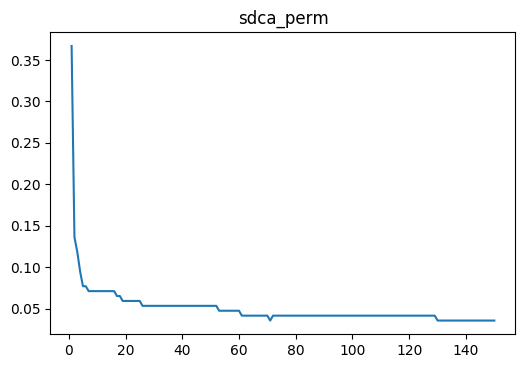

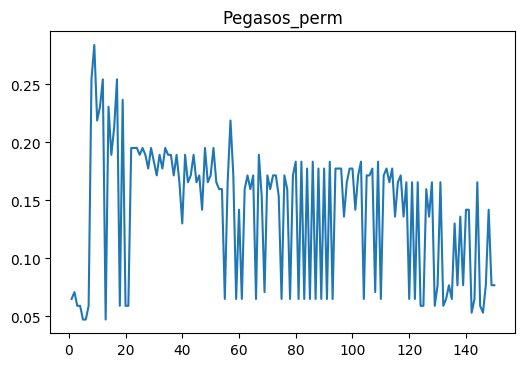

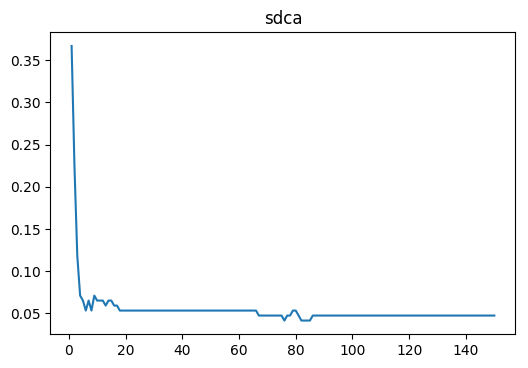

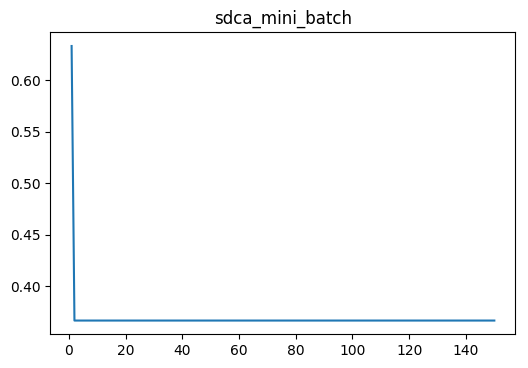

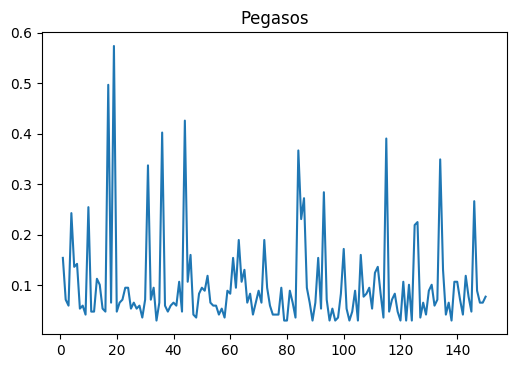

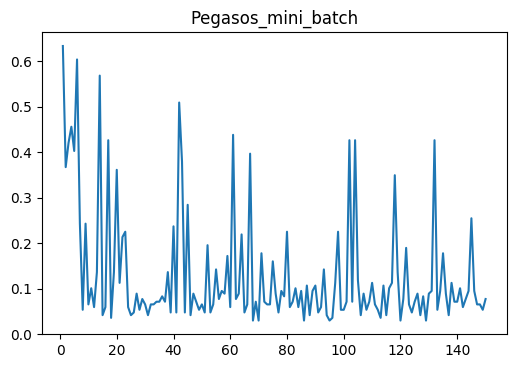

In [18]:
for i, j in error_dict.items():
    plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in j])
    plt.title(i)
    plt.show()

# STOP

***
<center>___The kernalized Pegasos algorithm___</center>
***
___Let___ $\alpha^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
>  Randomly pick $i$<br>
For all $j\neq i$:<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[j] = \alpha_{t-1}[j]$<br>
If $y_i \frac{1}{\lambda t}\sum\limits_j \alpha_{t-1}[j]y_i K(x_i,x_j) < 1:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[i] = \alpha_{t-1}[i]+1$<br>
Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[i] = \alpha_{t-1}[i]$<br>
 
___Output:___<br>
> return $\alpha_T$

***

In [16]:
kernels = {'linear_kernel':kernel.linear_kernel, 'polynomial_kernel':kernel.polynomial_kernel, 'rbf_kernel':kernel.rbf_kernel,
          'sigmoid_kernel':kernel.sigmoid_kernel, 'chi2_kernel':kernel.chi2_kernel}
def Pegasos_kernalized(X, y, kernel_choice = 'linear_kernel', lambda_ = 1, nb_iteration = 1000, projection = False):
    n = X.shape[0]
    alpha = [np.repeat(0, n)]
    ker_fun = kernels[kernel_choice]
    for t in tqdm(range(1,nb_iteration+1)):
        i = np.random.randint(0, n)
        j = [k for k in np.arange(n) if k!=i]
        if y[i]/(lambda_ * t) * sum([alpha[t-1][l] * y[i] * ker_fun(X[i].reshape(1, -1), X[l].reshape(1, -1)).item() for l in j]) < 1:
            e_i = np.zeros(n)
            e_i[i] = 1
            alpha.append(alpha[t-1]+e_i)
        else:
            alpha.append(alpha[t-1])
    return dual_primal(alpha[-1], X, lambda_)

In [17]:
Pegasos_kernalized_coefs = Pegasos_kernalized(X, y, 'linear_kernel', 1, 1000, projection = False)

100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]


In [18]:
np.linalg.norm(Pegasos_kernalized_coefs - sklearn_coefs, 2)

0.12720778759249748

The kernalized SVM solved thanks to kernalized Pegasos algorithm looses its performances compared to the non kernalized version. It seems that the kernalized version of Pegasos is not well suited to solve non-linear SVM if we cannot represent the kernel as a dot product of finite-dimensional feature vectors (i.e. it yields bad results when used with the RBF Kernel for example (which corresponds to infinite-dimensional feature vectors)).

See https://www.quora.com/Is-Pegasos-a-good-algorithm-for-non-linear-SVM

In this third part, we merge the 2 algorithms together in order to get better results

***
<center>___Procedure Modified-SGD___</center>
***
___Initialize:___ $w^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,n:$<br>
> Find $\alpha_t$ to maximize $-\phi_t^*(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)}+(\lambda t)^{-1} \alpha_tx_t||^2$<br>
Let $w^{(t)} = \frac{1}{\lambda t}\sum\limits_{i=1}^t \alpha_ix_i$<br>
return $\alpha$

***

***
<center>___Procedure SDCA with SGD Initialization___</center>
***
___Stage 1:___ call Procedure Modified-SGD and obtain $\alpha$<br>
___Stage 2:___ call Procedure SDCA with parameter $\alpha^{(0)} = \alpha$<br>
***